# Importing

In [25]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
seed=7
np.random.seed(seed)

In [27]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "/content/drive/MyDrive/EmotionDetectionProject/Datasets/RAVDESS/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:24]
     

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [28]:
emotion = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        file_path.append(audio + i + '/' + f)

In [29]:
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
#audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['emotion']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df
     


,emotion,path
0,happy,/content/drive/MyDrive/EmotionDetectionProject...
1,happy,/content/drive/MyDrive/EmotionDetectionProject...
2,neutral,/content/drive/MyDrive/EmotionDetectionProject...
3,calm,/content/drive/MyDrive/EmotionDetectionProject...
4,calm,/content/drive/MyDrive/EmotionDetectionProject...
...,...,...
1435,disgust,/content/drive/MyDrive/EmotionDetectionProject...
1436,disgust,/content/drive/MyDrive/EmotionDetectionProject...
1437,fear,/content/drive/MyDrive/EmotionDetectionProject...
1438,disgust,/content/drive/MyDrive/EmotionDetectionProject...


In [31]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
#df = pd.DataFrame(columns=['mfcc','chroma','contrast','zcr'])
df = pd.DataFrame(columns=['all'])

counter=0
#all=[]
for index,path in enumerate(audio_df.path):
    all=[]
    X, sample_rate = librosa.load(path,duration=3,sr=44100,offset=0.4)
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    mfcc=np.mean(mfcc,axis=1)
    print(mfcc.shape)
    all.extend(mfcc)
    
  
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 1)  
    print(log_spectrogram.shape)
    all.extend(log_spectrogram)
    
    
    
    # compute chroma energy (pertains to 12 different pitch classes)
    chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    chroma = np.mean(chroma, axis = 1)
    print(chroma.shape)
    all.extend(chroma)

    # # compute spectral contrast
    # contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
    # contrast = np.mean(contrast, axis= 1)
    # print(contrast.shape)
    # all.extend(contrast)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
    # which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
    zcr = librosa.feature.zero_crossing_rate(y=X)
    zcr = np.mean(zcr, axis= 1)
    print(zcr.shape)
    all.extend(zcr)

    rmse= librosa.feature.rms(y=X)
    rmse= np.mean(rmse, axis= 1)
    print(rmse.shape)
    all.extend(rmse)
    
    df.loc[counter] = [all]
    counter= counter +1
      


df.head()

df.fillna(0)

Streaming output truncated to the last 5000 lines.
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1,)
(1,)
(13,)
(128,)
(12,)
(1

,all
0,"[-510.42917, 88.897156, -10.856731, 13.8733015..."
1,"[-627.6197, 86.49145, -1.0733397, 10.716774, 1..."
2,"[-691.45056, 75.696625, 1.3426263, 13.293098, ..."
3,"[-700.8353, 92.12736, 8.16273, 12.540014, 9.03..."
4,"[-699.3719, 91.938416, 6.141221, 15.32896, 7.6..."
...,...
1435,"[-576.9649, 99.490105, -12.151792, 5.455798, -..."
1436,"[-562.95135, 103.18474, -25.163958, 2.9873943,..."
1437,"[-423.9425, 29.29459, -36.181564, -11.028387, ..."
1438,"[-449.00116, 70.74386, -34.522327, 3.016046, -..."


In [32]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['all'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)
# CHECK TOP 5 ROWS
df_combined.head()

,emotion,0,1,2,3,4,5,6,7,8,...,145,146,147,148,149,150,151,152,153,154
0,happy,-510.429169,88.897156,-10.856731,13.873302,-2.917888,11.282393,-12.083529,0.055235,-14.084307,...,0.496716,0.538851,0.482565,0.475468,0.478422,0.458237,0.413928,0.430139,0.200288,0.012994
1,happy,-627.619690,86.491447,-1.073340,10.716774,10.741106,11.965944,-6.123898,0.252303,-7.272675,...,0.593378,0.581810,0.521119,0.518351,0.496794,0.504587,0.576306,0.604148,0.233525,0.005377
2,neutral,-691.450562,75.696625,1.342626,13.293098,10.052478,13.702141,-5.172620,4.566328,-5.834104,...,0.553059,0.577135,0.526749,0.551836,0.586964,0.636032,0.624916,0.640884,0.316329,0.002579
3,calm,-700.835327,92.127357,8.162730,12.540014,9.037824,14.481430,-3.639717,7.255291,-7.665070,...,0.542912,0.538866,0.542395,0.581523,0.631351,0.661838,0.647411,0.612320,0.319083,0.003024
4,calm,-699.371887,91.938416,6.141221,15.328960,7.688680,14.217458,-3.267311,7.885510,-7.332531,...,0.589007,0.558360,0.531817,0.557998,0.590317,0.612714,0.604230,0.597155,0.292805,0.002990


In [33]:
df_combined.to_csv('/content/drive/MyDrive/EmotionDetectionProject/Code/1D CNN/mfcc+/1Dmffcs+(155)_Again',index=False)

In [34]:
# Read Data
df_ = pd.read_csv('/content/drive/MyDrive/EmotionDetectionProject/Code/1D CNN/1Dmffcs+(155)')

#df_.isnull().values.any()
     

In [35]:
data = df_.iloc[:, 1:]
labels = df_.iloc[:,:1]

In [36]:
labels= labels.replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, 'disgust':7, 'surprise':8})

In [37]:
# train,test = train_test_split(df_, test_size=0.20, random_state=0,
#                                stratify=df_[['emotion']])
X_train,X_rem,y_train,y_rem= train_test_split(data,labels, test_size=0.20, random_state=0, shuffle=True)
X_test,X_valid,y_test,y_valid= train_test_split(X_rem,y_rem, test_size=0.5, random_state=0, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(X_test.shape)
# X_test = test.iloc[:,1:]
# y_test = test.iloc[:,:1]
# print(X_test.shape)

# X_train
# #y_test


(1152, 155)
(1152, 1)
(144, 155)
(144, 155)


In [38]:

# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_valid = (X_valid - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_valid = np.array(X_valid)
y_valid= np.array(y_valid)
# ONE HOT ENCODE THE TARGET
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))#, num_classes=6)
y_test = to_categorical(lb.fit_transform(y_test))#, num_classes=8)
y_valid = to_categorical(lb.fit_transform(y_valid))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
# X_train = X_train[:,:,:,np.newaxis]
# X_test = X_test[:,:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
(1152, 155)
(144, 155)
(1152, 8)
(144, 8)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1296, 8)

In [39]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
#model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=300, validation_data=(X_test, y_test),callbacks=[checkpoint])
model_history=model.fit(X_train,y_train,batch_size=32, epochs=300, validation_data=(X_valid, y_valid),callbacks=[checkpoint])
          

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 155, 256)          2304      
                                                                 
 conv1d_15 (Conv1D)          (None, 148, 256)          524544    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 74, 256)          0         
 g1D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 74, 256)          1024      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 74, 256)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 74, 256)          

Epoch 1/300
35/36 [============================>.] - ETA: 0s - loss: 4.7664 - accuracy: 0.1446
Epoch 1: val_accuracy improved from -inf to 0.21528, saving model to SER_best_initial_model.hdf5
36/36 [==============================] - 8s 36ms/step - loss: 4.7557 - accuracy: 0.1432 - val_loss: 4.2456 - val_accuracy: 0.2153
Epoch 2/300
33/36 [==========================>...] - ETA: 0s - loss: 4.0222 - accuracy: 0.2102
Epoch 2: val_accuracy did not improve from 0.21528
36/36 [==============================] - 1s 15ms/step - loss: 3.9932 - accuracy: 0.2135 - val_loss: 3.6007 - val_accuracy: 0.2153
Epoch 3/300
36/36 [==============================] - ETA: 0s - loss: 3.3738 - accuracy: 0.2240
Epoch 3: val_accuracy improved from 0.21528 to 0.22222, saving model to SER_best_initial_model.hdf5
36/36 [==============================] - 1s 17ms/step - loss: 3.3738 - accuracy: 0.2240 - val_loss: 3.1392 - val_accuracy: 0.2222
Epoch 4/300
36/36 [==============================] - ETA: 0s - loss: 2.9858 -

5/5 [==============================] - 0s 7ms/step - loss: 1.3921 - accuracy: 0.6944
Loss of the model is -  1.3920584917068481
5/5 [==============================] - 0s 7ms/step - loss: 1.3921 - accuracy: 0.6944
Accuracy of the model is -  69.44444179534912 %
5/5 [==============================] - 0s 7ms/step


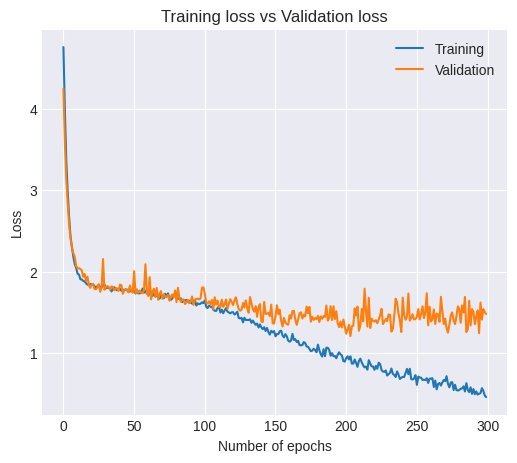

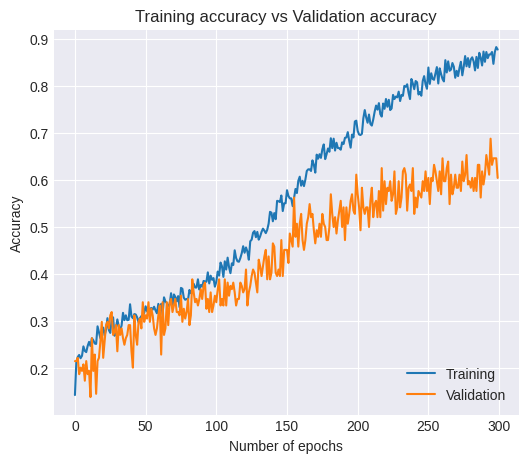

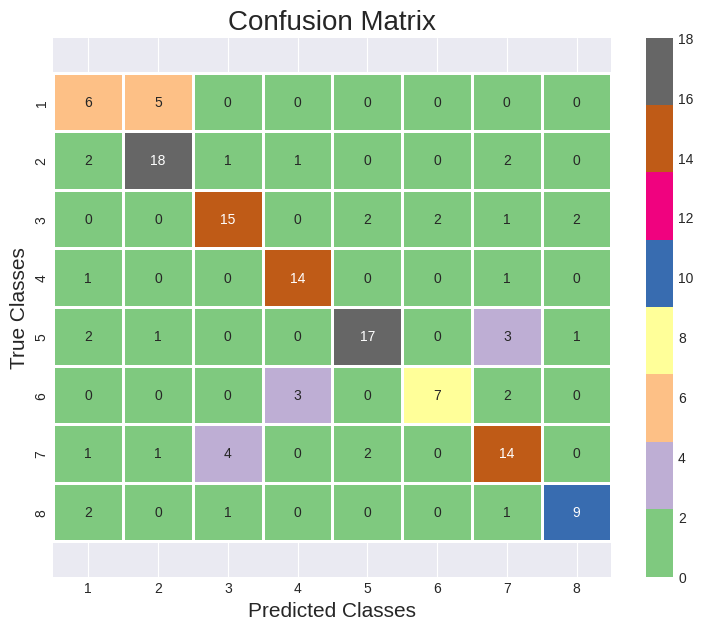

              precision    recall  f1-score   support

       angry       0.43      0.55      0.48        11
        calm       0.72      0.75      0.73        24
     disgust       0.71      0.68      0.70        22
        fear       0.78      0.88      0.82        16
       happy       0.81      0.71      0.76        24
     neutral       0.78      0.58      0.67        12
         sad       0.58      0.64      0.61        22
    surprise       0.75      0.69      0.72        13

    accuracy                           0.69       144
   macro avg       0.70      0.68      0.69       144
weighted avg       0.70      0.69      0.70       144



In [40]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-MFCC.png')
plt.show() 

print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise'])) 

(0.0, 1.0)

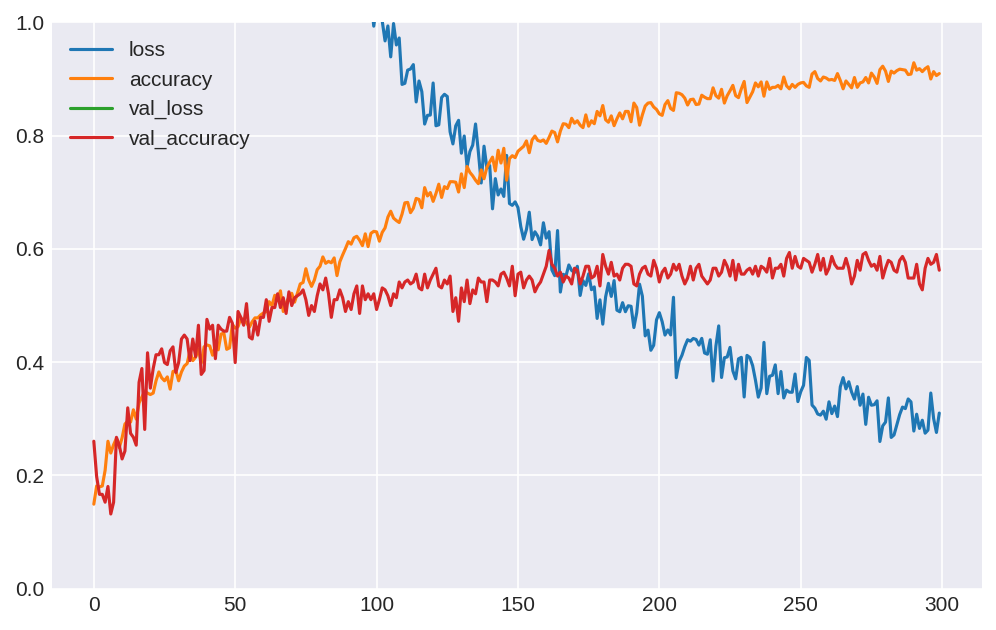

In [ ]:
plt=pd.DataFrame(model_history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

In [ ]:
tf.keras.models.save_model(model,"/content/drive/MyDrive/EmotionDetectionProject/Code/1D CNN/mfcc+/0.66_Extendedmfcc+.hdf5") 
#tf.keras.models.load_model()